# Power dynamics: exploring the relationship between coal and electricity production in South Africa


South Africa has experienced [load shedding](http://loadshedding.eskom.co.za/LoadShedding/Description) for the [past 12 years](https://www.fin24.com/Economy/Eskom/sunday-read-load-shedding-through-the-years-and-how-eskom-has-struggled-to-keep-the-lights-on-20190324). This notebook looks at the impact of coal production on the production of electricity.

**Question:** Is there a significant relationship between coal production and electricity production?

We explore this relationship using the [regression slope test](https://stattrek.com/regression/slope-test.aspx), having a regression line of the format:
$$
Y=B_{0}+B_{1} X
$$
where $B_0$ is an the intercept, $B_{1}$ is the slope (also called the coefficient), $X$ is coal and $Y$ is electricity. If there is a significant relationship between the $X$ and $Y$ variables, the slope will not equal zero. 

Thus, the **hypothesis** is as follows:
$$
\begin{array}{l}{\mathrm{H}_{\mathrm{0}} : \mathrm{B}_{1}=0} \\ {\mathrm{H}_{\mathrm{1}} : \mathrm{B}_{1} \neq 0}\end{array}
$$
Where, the null hypothesis is having slope equal zero, and the alternative hypothesis having a slope not equal to zero.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns 

sns.set_style("darkgrid")

## 1. Loading Data
I pre-proccessed the data during the Exploratory Data Analysis (EDA) stage of this research. From that I created monthly time-series datasets of Coal usage from 2003 to 2019 February and Electricity usage from 2000 to 2019 February.

In [2]:
# Load Data Processed from EDA
coal = pd.read_pickle("Dataset/processed_coal_data.pkl")
elec = pd.read_pickle("Dataset/processed_elec_data.pkl")

In [3]:
# Display the Electricity Data
elec.head()

,Giggawatt-Hours
Month,
2000-01-01,14829.0
2000-02-01,14695.0
2000-03-01,16219.0
2000-04-01,15375.0
2000-05-01,17044.0


In [4]:
# Display the Coal Data
coal.head()

,Amount
Month,
2003-01-01,86.46
2003-02-01,82.88
2003-03-01,87.89
2003-04-01,89.67
2003-05-01,101.82


In [5]:
# The Coal Data only starts in 2003, so we can delete 2000-2003 in Electricity
if coal.size!=elec.size:
    elec = elec[3*12:] # Delete three years of data
# Check both datasets have the same features
print("Months equal:",coal.size==elec.size)
print("Starts equal:",coal.index[0]==elec.index[0])
print("Ends equal:  ",coal.index[-1]==elec.index[-1])

Months equal: True
Starts equal: True
Ends equal:   True


## 2. Exploring data
Basic plots and calculations to better understand the data

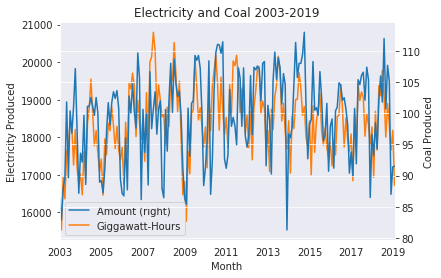

In [6]:
# Plotting both variables together
elec_and_coal = coal.join(elec)

# Create a Plot with two Y values
ax = elec_and_coal.plot(secondary_y=['Amount'])
ax.set_title("Electricity and Coal 2003-2019")
ax.set_ylabel('Electricity Produced')
ax.right_ax.set_ylabel('Coal Produced')
plt.show()

This gives us an indication that there is a high amount of correlation between the years 2003-2019 - as both graphs are quite similar. Furthermore, there seems to be a some amount of seasonality to this data - which we will explore later.

Firstly, we can find out exactly how correlated they are by calculating the correlation coefficient between the two variables:

In [7]:
def corr_coef(x, y):
    """
    Given two series, find out how correlated they are
    """
    x_m = (x - np.mean(x))
    y_m = (y - np.mean(y))
    r = np.sum(x_m * y_m) / np.sqrt(np.sum(x_m**2) * np.sum(y_m**2))
    return r

In [8]:
# Get both Dataframes as a series and get corr coeff
coal_series= coal.iloc[:,0]
elec_series = elec.iloc[:,0]
print("Correlation coefficient between electricity and coal production is",corr_coef(elec_series,coal_series))

Correlation coefficient between electricity and coal production is 0.6509097952280685


A value of $0.65$ means that the two variables have a [moderately strong positive correlation](https://statisticsbyjim.com/basics/correlations/). This likely means that there is a relationship of some kind between coal and electricity.

Now, we can find out if the data is stationary - which means that the mean, variance and autocorrelation do not change significantly over time. Stationarity [can make time series easier to model](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm). We can use the [Augmented Dickey-Fuller test (ADF)](https://machinelearningmastery.com/time-series-data-stationary-python/) to determine if the data is stationary:
$$
\begin{aligned}
    H_0&: \text{Time series has a unit root and is not stationary - it has some time dependent structure}\\
    H_1&: \text{Time series does not have a unit root, it is stationary - does not have a time dependent structure}
\end{aligned}
$$

If the p-value returned from the test is below or equal to 0.05 then we reject the null hypothesis - otherwise we maintain it.

In [9]:
def is_stationary(data):
    """
    Takes in an array of values and indicates whether it is stationary.
    """
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <=0.05:
        print("This data is Stationary")
    else:
        print("This data is not Stationary")
    print("\n")

In [10]:
is_stationary(coal.iloc[:,0].values)
is_stationary(elec.iloc[:,0].values)

ADF Statistic: -2.682975
p-value: 0.077031
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
This data is not Stationary


ADF Statistic: -2.740101
p-value: 0.067352
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
This data is not Stationary




The above data is not stationary, which indicates that there could be some seasonal affects, trends and other structures that depend on the time index. We can decompose the data to better understand the different aspects at play:

In [11]:
def get_decomposition(timeseries_data, plot_output=False):
    """
    Returns the seasonal and residual components of
    the given time series
    """
    decomposition = seasonal_decompose(timeseries_data, model='additive')
    seasonal = decomposition.seasonal
    resid = decomposition.resid
    trend = decomposition.trend
    if plot_output:
        decomposition.plot()
        plt.show()
    return seasonal, resid, trend

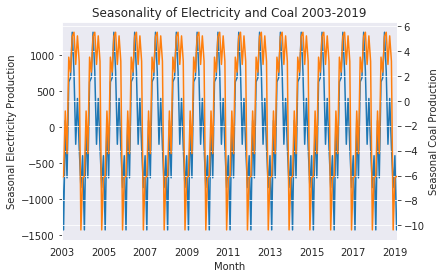

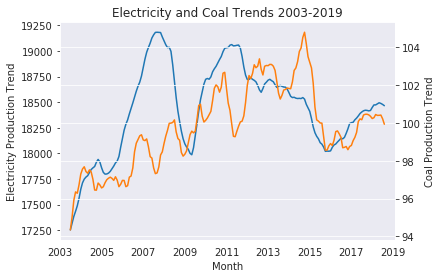

In [12]:
# Get decompositions
elec_season, elec_resid, elec_trend = get_decomposition(elec)
coal_season, coal_resid, coal_trend = get_decomposition(coal)


# Join DFs
seasons = elec_season.join(coal_season)
trends = elec_trend.join(coal_trend)

# Plot Seasonality
ax = seasons.plot(secondary_y=['Amount'])
ax.set_title("Seasonality of Electricity and Coal 2003-2019")
ax.set_ylabel('Seasonal Electricity Production')
ax.right_ax.set_ylabel('Seasonal Coal Production')
ax.get_legend().remove()
plt.show()

# Plot Trends
ax = trends.plot(secondary_y=['Amount'])
ax.set_title("Electricity and Coal Trends 2003-2019")
ax.set_ylabel('Electricity Production Trend')
ax.right_ax.set_ylabel('Coal Production Trend')
ax.get_legend().remove()
plt.show()

Visually, the seasonality of both variables looks quite similar. The trend doesn't look very similar. We can measure the strength of seasonality $F_S$ and trend $F_T$ by using the following equations
$$
F_{S}=\max \left(0,1-\frac{\operatorname{Var}\left(R_{t}\right)}{\operatorname{Var}\left(S_{t}+R_{t}\right)}\right)
$$

And the strength of trend by using the equation:

$$
F_{T}=\max \left(0,1-\frac{\operatorname{Var}\left(R_{t}\right)}{\operatorname{Var}\left(T_{t}+R_{t}\right)}\right)
$$

If $F_s$ or $F_t$ is close to 0 it exhibits almost no seasonality or trend, whereas strong seasonality or trend will be close to 1. (Equations from [Forecasting: principles and practice](https://otexts.com/fpp2/seasonal-strength.html))

In [13]:
def strength(varname, t_or_s, Rt,seasonal=True):
    """
    Returns the seasonality strength given the
    Seasonality and Residuals
    """
    strength = float(1-(Rt.var()/(t_or_s.var() + Rt.var())))
    if strength < 0:
        strength = 0
    
    if seasonal:  
        print("Seasonality strength of",varname,"is",round(strength,2))
    else:
        print("Trend strength of",varname,"is",round(strength,2))

In [14]:
strength("coal",coal_season, coal_resid)
strength("electricity",elec_season, elec_resid)
strength("coal",coal_trend, coal_resid,seasonal=False)
strength("electricity",elec_trend, elec_resid,seasonal=False)

Seasonality strength of coal is 0.65
Seasonality strength of electricity is 0.89
Trend strength of coal is 0.24
Trend strength of electricity is 0.72


Both variable's seasonality are quite strong, and based on the graphs - are quite constant and correlated.
Electricity has a strong trend to it as well.


As the seasonality of both variables is strong, its best to adjust our data in order to reduce the amount of seasonality. We used additive decomposition, hence to get the seasonally adjusted data we simply have to reduce the data by the seasonal component as  $y_t - S_t$

In [15]:
def adjust_season(name, time_series, seasonality, plot_output=True):
    adjusted = time_series - seasonality
    if plot_output:
        plt.plot(time_series, label="Initial")
        plt.title("Seasonally Adjusted Time Series for "+name)
        plt.plot(adjusted,color='black', label="Adjusted")
        plt.legend(loc='upper left')
        plt.show()
    return adjusted

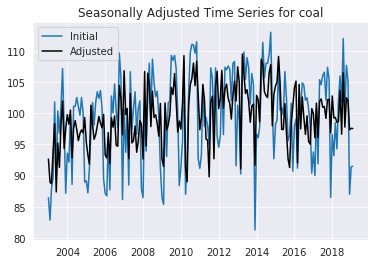

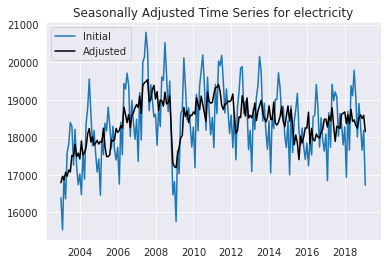

In [16]:
coal_adj = adjust_season("coal", coal, coal_season)
elec_adj = adjust_season("electricity", elec, elec_season)

Now we can check for stationarity again:

In [17]:
is_stationary(coal_adj.iloc[:,0].values)
is_stationary(elec_adj.iloc[:,0].values)

ADF Statistic: -5.443041
p-value: 0.000003
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
This data is Stationary


ADF Statistic: -3.571174
p-value: 0.006337
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
This data is Stationary




The data is now stationary, thus we won't reduce it by the trend decompose. 

We can compare the correlation between coal and electricity to see if the majority of it was based on the seasonality:

In [18]:
print("Correlation coefficient between electricity and coal production is",corr_coef(elec_adj.iloc[:,0].values,coal_adj.iloc[:,0].values))

Correlation coefficient between electricity and coal production is 0.40764240151447995


Thus, we can see that the previous value of 0.65 for our correlation was mainly due to the seasonality of the data and the relationship between electricity and coal is not as strong as initially thought.

However, we can still explore their relationship further and gain value from using other statistical techniques.interact with one another.

## 3. Creating Models
Using different techniques to create models with the data

In [19]:
# Join the two and retitle them
elec_and_coal_adj = coal_adj.join(elec_adj)
if 'Amount' in elec_and_coal_adj:
    elec_and_coal_adj.rename(columns={'Amount':'Coal','Giggawatt-Hours':'Electricity'},inplace=True)
elec_and_coal_adj.head()

,Coal,Electricity
Month,,
2003-01-01,92.649591,16788.217043
2003-02-01,88.945008,16961.519821
2003-03-01,88.716035,16859.153154
2003-04-01,93.915674,17064.205932
2003-05-01,98.325091,16961.692043


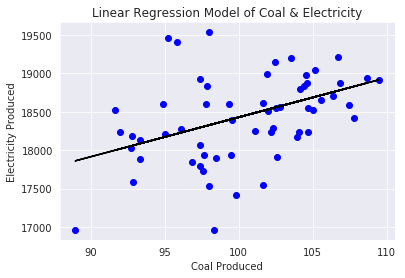

Coefficient: 51.42
Intercept: 13286.0
Mean squared error: 265316.04
Variance score: 0.17


In [20]:
x = coal_adj
y = elec_adj
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101)

model = LinearRegression()
model.fit(x_train,y_train)
params = np.append(model.intercept_, model.coef_)
predicted = model.predict(x_test)
plt.title("Linear Regression Model of Coal & Electricity")
plt.scatter(x_test, y_test,color='blue')
plt.plot(x_test, predicted, color='black')
plt.ylabel("Electricity Produced")
plt.xlabel("Coal Produced")
plt.show()

print('Coefficient:',round(model.coef_[0][0],2))
print("Intercept:",round(model.intercept_[0]))
print("Mean squared error: %.2f"% mean_squared_error(y_test, predicted))
print('Variance score: %.2f' % r2_score(y_test, predicted))

In [21]:
def print_p_values(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = (sum((y_test.values-predicted)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

In [22]:
print_p_values(x_test,y_test,predicted,params)

Coefficients       51.4226
Standard Errors    14.0860
t values            3.6510
P-Values            0.0010
Name: 1, dtype: float64


The estimated regression line is of the form:
$$
\hat{y}_t = 13286 + 51.42x_t
$$
It has a positive slope, which indicates a positive relationship between the coal production and electricity production. The variance score indicates the explained variance, where [1 is perfect prediction](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html), hence 0.17 is quite a low variance indicating the model is not accurate.

However, we have met the criteria for our alternative hypothesis as the coefficient does not equal zero, or $B_1 \neq 0$ and we can see that the P-value is 0.001 - which means that it is a statistically significant result.

To visualise how accurate the model is we can use the model's predictions and plot them alongside the the actual values:

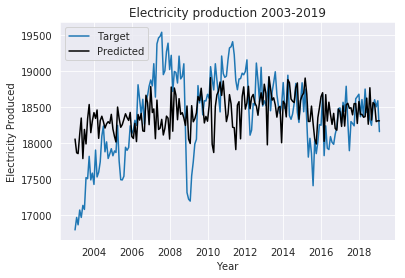

In [23]:
# Predict the values
pred = model.predict(coal_adj)
plt.plot(elec_adj, label="Target")
plt.title("Electricity production 2003-2019")
plt.plot(elec_adj.index,pred,color='black', label="Predicted")
plt.legend(loc='upper left')
plt.ylabel("Electricity Produced")
plt.xlabel("Year")
plt.show()

As displayed - our model is not very effective. We can attempt to optimise it. The data used to train the model was 70% of the data, which may not be necessary, the model may benefit from using batches of the period. We can predict a point based on the past few months coal production, and do that for every month:

In [24]:
def predictions_from_period(period=12,y=coal_adj, x=elec_adj, plot=True, cumulative=False):
    """
    Predicts each y val, based on the past period_length x vals
    cumulative: predict the y vals including all previous x vals
    """
    assert(len(x)==len(y))
    observations = len(x)
    preds = []
    dates = []
    coefficients = []
    model = LinearRegression()
    for i in range(period,observations-1,):
        if cumulative:
            # Includes all the previous values up until i
            x_train = x.iloc[:i]
            y_train = y.iloc[:i]
        else:
            # Only include current period values
            x_train = x.iloc[i-period:i]
            y_train = y.iloc[i-period:i]
            x_test = np.array(x.iloc[i]).reshape(-1,1)
            y_test = y.iloc[i]
            model.fit(x_train,y_train)
            prediction = model.predict(x_test)
            coefficients.append(float(model.coef_[0][0]))
            dates.append(y.index[i])
            preds.append(prediction[0][0])
    y_true = y.iloc[period+1:]
    if plot:
        plt.plot(y_true, label="Target")
        plt.title("Predictions based on "+str(period)+" months of data")
        plt.plot(dates,preds,color='black', label="Predicted")
        plt.legend(loc='upper left')
        plt.show()
    return coefficients, mean_absolute_error(y_true, preds), mean_squared_error(y_true, preds), r2_score(y_true,preds)

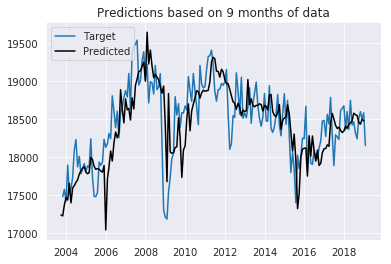

Mean Absolute Error: 313.3 Mean Squared Error: 174255.26 Variance Score: 0.3 RMSE 417.44


In [25]:
max_r = 0
max_i = 0
for i in range(3,13):
    coeff, mae, mse, r2 = predictions_from_period(period=i, x=coal_adj, y=elec_adj,plot=False)
    if r2 > max_r:
        max_r = r2
        max_i = i
coeff, mae, mse, r2 = predictions_from_period(period=max_i, x=coal_adj, y=elec_adj,plot=True)
print("Mean Absolute Error:", round(mae,2), "Mean Squared Error:",round(mse,2),"Variance Score:",round(r2,2), "RMSE",round(np.sqrt(mse),2))

This goes through each period length from 3 months till 12 months, and checks the accuracy of using coal values for a period to predict the electricity values. It achieves a better variance score of 0.30 compared to our previous method which achieved 0.17 - but it is still not very accurate.

We can visualise the coefficients, and see if any of them were zero and better understand the change in slope:

There are 0 zero value coefficients


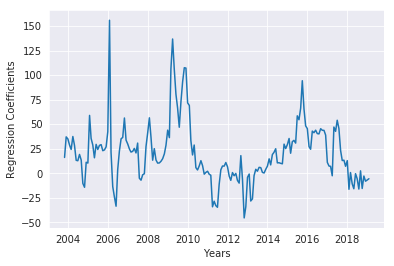

In [26]:
coeff = np.array(coeff)
zeroes = coeff[coeff == 0]
print("There are",len(zeroes),"zero value coefficients")
plt.plot(elec_adj.index[10:],coeff)
plt.ylabel("Regression Coefficients")
plt.xlabel("Years")
plt.show()

Seeing as there were no coefficients of zero, our alternative hypothesis has been reinforced.

## 4. Conclusion
This notebook aimed to find out whether there was a significant relationship between the coal production and electricity production in South Africa. The criteria for our alternative hypothesis was met with linear regression - indicating that there is a significant relationship between the two. However, the correlation coefficients from both datasets indicate that there may be other factors playing a role, hence, adding variables and exploring multi-variate techniques may lead to better results.